# Compute precise decomposition of exponential and Matérn kernel

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from kl_decomposition import error_estimates, misc

all_kernels = {}
all_a, all_b, all_vals = misc.get_kl_decomp("data/exp.json")
all_kernels["exp"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}
all_a, all_b, all_vals = misc.get_kl_decomp("data/matern.json")
all_kernels["matern"] = {"all_a": all_a, "all_b": all_b, "all_vals": all_vals}

Loading decomposition from data/exp.json...
Loading decomposition from data/matern.json...


# Computing the KL decomposition of selected covariance functions

In [ ]:
tols = [1e-2, 1e-4, 1e-6]
eigenvectors_compute = [1, 15, 30]
degrees = np.arange(2, 63)
kernels = {"exp": lambda x, y: np.exp(-np.abs(x - y)),
           "matern": lambda x, y: (1 + np.sqrt(5) * np.abs(x - y) + (5 / 3) * np.abs(x - y)**2) * np.exp(-np.sqrt(5) * np.abs(x - y))}

results_all = {}

for kernel in kernels.keys():
    results_ker = {}
    for tol in tols:
        all_a, all_b, all_vals = misc.get_decomp_at_tol(all_kernels[kernel], tol)
        a_coeff = all_a
        b_coeff = np.exp(all_b)
        A_all = misc.get_kl_decomp_gal(b_coeff, comp_degree=100)

        err_all = []

        for degree in degrees:
            lams, eigvecs = misc.get_kl_decomp_from_gal_to_operators(
                a_coeff, A_all, comp_degree=degree, N_eval=1000
            )
            err_degree = []
            for phi_i in eigenvectors_compute:
                if len(lams) > phi_i:
                    err_degree.append(error_estimates.residual_l2(
                        c=kernels[kernel],
                        u=eigvecs[phi_i-1],
                        lam=lams[phi_i-1],
                        quad_outer=200,
                        quad_inner=200,
                    ))
                else:
                    err_degree.append(np.nan)
            
            err_all.append(err_degree)

        results_ker[tol] = err_all
    results_all[kernel] = results_ker

# Plotting

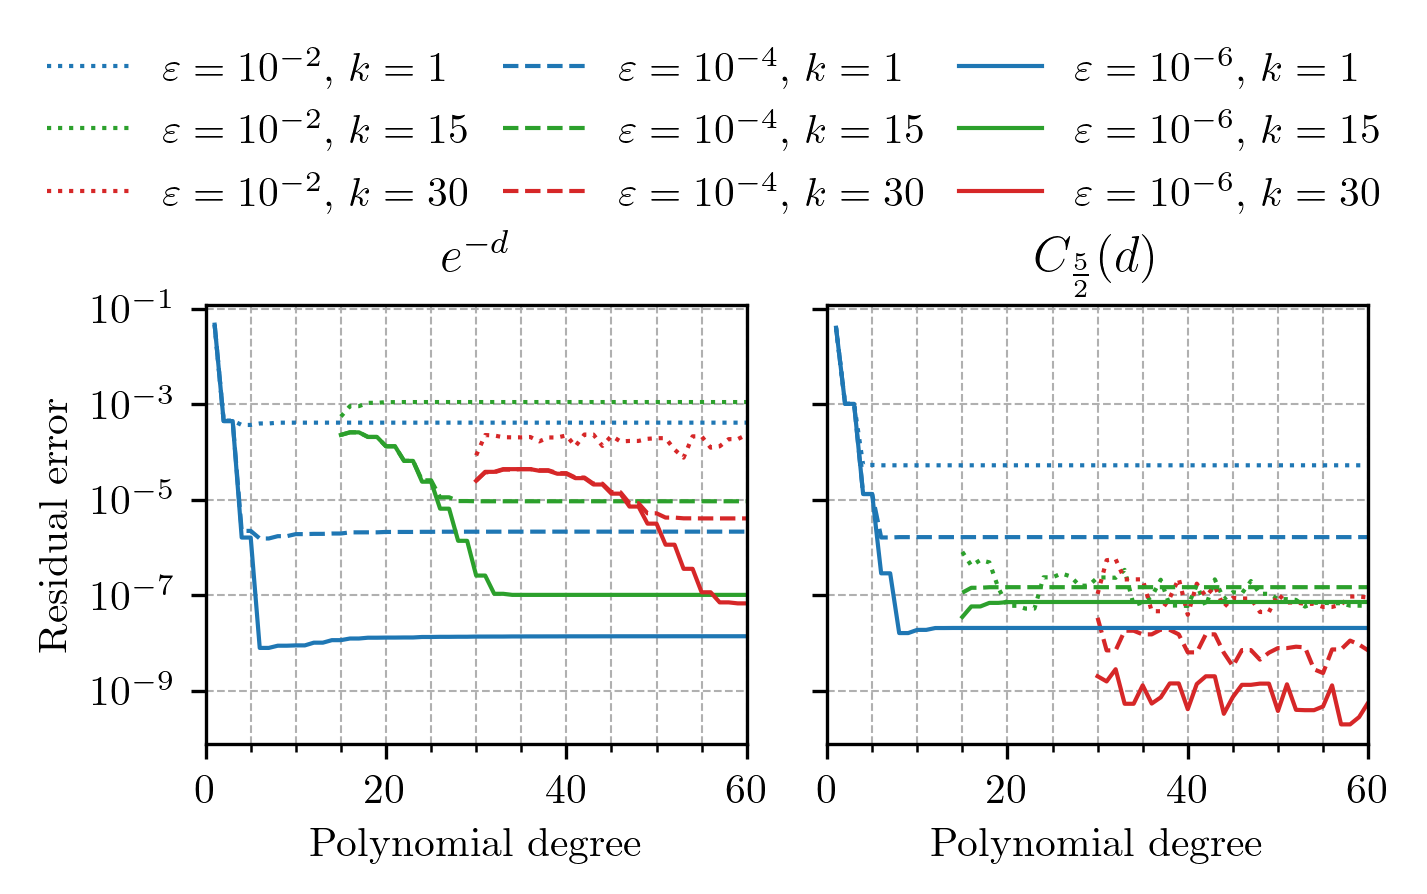

In [ ]:
# Plot styling
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})


# Style mappings
colors_phi = {1: "tab:blue", 15: "tab:green", 30: "tab:red"}
linestyles_tol = {1e-2: ":", 1e-4: "--", 1e-6: "-"}
title_map = {"exp": r"$e^{-d}$", "matern": r"$C_{\frac{5}{2}}(d)$"}

# Create subplots
n_kernels = len(results_all)
fig, axes = plt.subplots(
    nrows=1,
    ncols=n_kernels,
    figsize=(4.8, 2.5),
    dpi=300,
    sharey=True
)
if n_kernels == 1:
    axes = [axes]

# Plot each kernel
for ax, (kernel_name, res_ker) in zip(axes, results_all.items()):
    for tol in tols:
        err_all = res_ker[tol]
        exponent = int(np.log10(tol))
        for j, phi_i in enumerate(eigenvectors_compute):
            errs = [deg_res[j] for deg_res in err_all]
            label = fr"$\varepsilon=10^{{{exponent}}}$, $k={phi_i}$"
            ax.plot(
                np.array(degrees)-1,
                errs,
                color=colors_phi[phi_i],
                linestyle=linestyles_tol[tol],
                label=label,
                linewidth=1.0
            )
    
    ax.set_xlim(0, 60)
    ax.set_yscale("log")
    ax.set_xlabel("Polynomial degree")
    ax.set_title(title_map.get(kernel_name, kernel_name), pad=8)
    ax.set_xticks(np.arange(0, 61, 20))
    ax.set_xticklabels([str(x) for x in np.arange(0, 61, 20)])
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.minorticks_on()
    
    # ax.yaxis.set_minor_locator(AutoMinorLocator())


axes[0].set_ylabel("Residual error")

# Reduce space between subplots
fig.subplots_adjust(wspace=0.05)

# Common legend above
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.2),
    ncol=3,
    frameon=False,
    columnspacing=0.8,
)

fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("residual_convergence.pdf", bbox_inches="tight", dpi=300, pad_inches=0)
plt.show()

# Create table with correspondigs eigenvalues for reference

In [ ]:
lam_all = {}
for kernel in kernels.keys():
    all_a, all_b, all_vals = misc.get_decomp_at_tol(all_kernels[kernel], 1e-6)
    a_coeff = all_a
    b_coeff = np.exp(all_b)
    A_all = misc.get_kl_decomp_gal(b_coeff, comp_degree=100)

    lams, eigvecs = misc.get_kl_decomp_from_gal_to_operators(
            a_coeff, A_all, comp_degree=100, N_eval=1000)
    lam_all[kernel] = lams

In [ ]:
# Indices we want (0-based for Python)
selected_indices = [0, 14, 29]

# Create LaTeX table header
latex = []
latex.append(r"\begin{tabular}{lccc}")
latex.append(r"\toprule")
latex.append(r"Kernel & $\lambda_1$ & $\lambda_{15}$ & $\lambda_{30}$ \\")
latex.append(r"\midrule")

# Fill in the rows
for kernel, lams in lam_all.items():
    values = []
    for idx in selected_indices:
        if idx < len(lams):
            values.append(misc.to_latex_sci(lams[idx]))
        else:
            values.append("--")
    row = f"{kernel} & " + " & ".join(values) + r" \\"
    latex.append(row)

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")

# Join all lines and print
latex_table = "\n".join(latex)
print(latex_table)

\begin{tabular}{lccc}
\toprule
Kernel & $\lambda_1$ & $\lambda_{15}$ & $\lambda_{30}$ \\
\midrule
exp & $7.388\cdot 10^{-1}$ & $1.031\cdot 10^{-3}$ & $2.409\cdot 10^{-4}$ \\
matern & $8.950\cdot 10^{-1}$ & $3.210\cdot 10^{-9}$ & $5.661\cdot 10^{-16}$ \\
\bottomrule
\end{tabular}
